In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

## 1) Importing datasets
After data cleaning and transformation (Appendix B) and sampling (Appendix C)

In [2]:
# Creating list with names of files exported after sampling
csv_files = [file for file in os.listdir("./data/csv_balanced/") if file.endswith('.csv')]

# Creating an empty list to store dataframes
list_df = []

# Loop to import each file and append to the created list
for csv in csv_files:
    df = pd.read_csv(os.path.join("./data/csv_balanced/", csv))
    list_df.append(df)

# 2) Standardising features


In [5]:
list_std = []

for df in list_df:
    std_scaler = StandardScaler()
    cols = df.columns.difference(['fraud_bool'])
    df[cols] = std_scaler.fit_transform(df[cols])
    list_std.append(df)

# 3) Principal Components Analysis
Reducing the number of features by creating principal components

In [6]:
# Function to get explained variance ratio for N number of components
def explained_var(dataframe_number, file_name):
    var_n = range(1, len(list_std[dataframe_number].columns), 2)

    var_ratio = []

    for num in var_n:
        pca = PCA(n_components=num)
        pca.fit(list_std[dataframe_number].loc[:, list_std[dataframe_number].columns != 'fraud_bool'])
        var_ratio.append(np.sum(pca.explained_variance_ratio_))

    plt.figure(figsize=(3,2),dpi=100)
    plt.grid()
    plt.plot(var_n,var_ratio,marker='o', color='#3f7f93', markerfacecolor='#3f7f93')
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    plt.savefig('./img/' + file_name + '.png')

    #plt.title('Number of components vs. Explained Variance Ratio')

Checking explained variance with different number of components

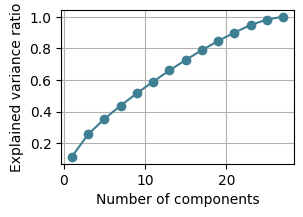

In [7]:
explained_var(1, 'fig3_PCA')

Creating two new lists:
- Dataframes with Outcome variable and principal components;
- Tables with loadings of each component

In [8]:
# Based on 'optimal' explained variance as reference, create N number of components
n_components = 15
list_pca = []
list_loadings = []

for df in list_std:
    # Defining name of the principal components
    col_names = ['PC%s' % _ for _ in range(1, n_components+1)]

    # Defining columns that will be used in PCA
    cols = df.columns.difference(['fraud_bool'])

    # Running PCA
    pca = PCA(n_components = n_components)
    pca_matrix = pca.fit_transform(df[cols])

    # Adding PCs to dataframe with Outcome variable and appending to list
    pca_df = pd.DataFrame(data = pca_matrix, columns= col_names)
    final_df = pd.concat([df['fraud_bool'], pca_df], axis=1)
    list_pca.append(final_df)

    # Extracting loadings of each component for each variable and appending to list
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    pca_load = pd.DataFrame(data = loadings, columns=col_names, index=df.columns[df.columns !=  'fraud_bool'])
    list_loadings.append(pca_load)


In [9]:
list_loadings[1].style.apply(lambda x: ["background: red" if v < -0.2 else ("background: green" if v > 0.2  else "") for v in x], axis = 1)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
income,0.089528,0.048378,0.255388,-0.220634,-0.390136,-0.132042,0.164496,-0.125361,0.245469,-0.074106,0.171839,-0.193910,-0.006953,-0.158365,0.636087
name_email_similarity,0.079381,0.047173,0.224526,-0.175510,-0.604457,-0.033513,0.084870,-0.225768,0.207718,-0.042058,0.224189,-0.019043,-0.020407,0.044814,-0.243415
prev_address_months_count,-0.485170,0.516132,-0.324129,-0.306252,0.119645,-0.138298,0.007917,-0.070226,0.030696,0.014417,-0.014855,-0.047512,0.092462,0.013939,0.024629
current_address_months_count,-0.128146,0.460072,0.288907,-0.140540,-0.066405,0.213210,-0.359732,0.139227,0.016171,0.033637,-0.020142,0.243352,-0.024361,-0.054972,-0.023008
customer_age,-0.255380,0.599109,0.240285,0.210590,0.006947,0.042065,0.175734,0.057067,0.104033,-0.088910,-0.312751,-0.069138,-0.104499,0.016090,0.081474
days_since_request,0.439796,-0.388403,-0.312221,-0.225595,0.038676,-0.060594,-0.091560,-0.224262,-0.179978,0.045564,0.327775,0.078605,0.115190,0.087629,-0.036704
intended_balcon_amount,0.067288,-0.108183,-0.076200,0.217338,0.014778,-0.138309,0.258197,0.366441,0.244453,-0.051198,0.044395,0.631545,0.371004,0.071737,0.240746
zip_count_4w,0.058223,0.156010,-0.036262,0.410558,-0.253913,-0.326155,-0.184980,0.136399,-0.388191,-0.100451,0.102582,-0.038168,-0.075368,0.040944,0.101412
velocity_6h,0.033496,0.070100,-0.207164,0.220668,-0.200293,0.280519,0.173707,-0.324448,-0.129688,0.136651,-0.219560,-0.153173,0.665821,-0.076734,0.013352
velocity_24h,-0.016130,0.078953,-0.142730,0.032308,-0.144022,-0.017138,0.164970,-0.242056,-0.213596,0.695541,-0.131106,0.353001,-0.356850,-0.182500,0.157681


# 4) Correlation analysis

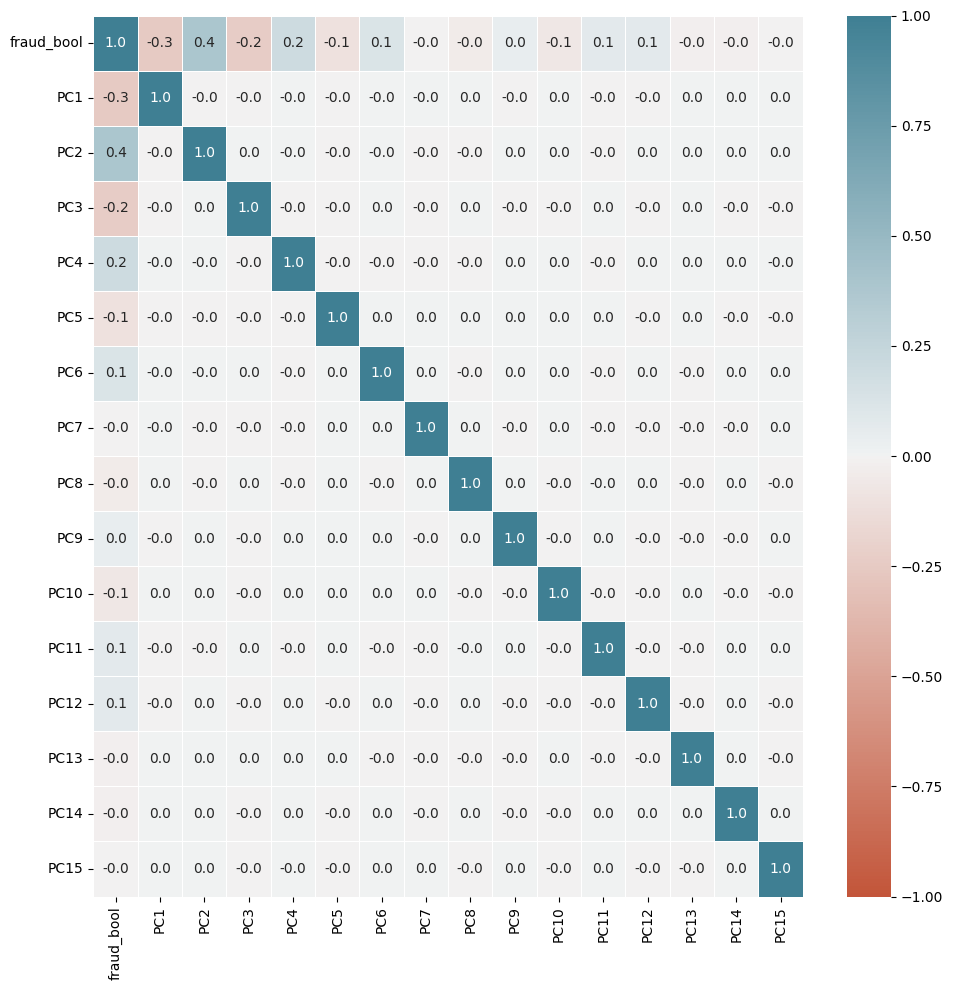

In [10]:
# Defining function to plot correlation heatmap of one of the dataframes in the list
def plot_heatmap(dataframe, plot_name):
    f,ax = plt.subplots(figsize=(10, 10))
    heatmap = sns.heatmap(
        dataframe.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,
        cmap=sns.diverging_palette(20, 220, as_cmap=True),
        vmin=-1, vmax=1
    )
    #heatmap.set_title('Correlation heatmap', fontdict={'fontsize':20}, pad=16)
    plt.tight_layout()
    plt.savefig('./img/' + plot_name + '.png')
    plt.show()
    plt.close()

# Plot heatmap
plot_heatmap(list_pca[1], 'fig4_corr_PCA')

# 5) Logistic regression

In [11]:
# Creating function specifying the model
def backward_elimination(X, y, sig_lvl=0.05):
    num_vars = len(X.columns)
    for i in range(0, num_vars):
        regressor_Logit = sm.Logit(y.astype(float), X.astype(float)).fit()
        max_var = max(regressor_Logit.pvalues)
        if max_var > sig_lvl:
            for j in range(0, num_vars - i):
                if (regressor_Logit.pvalues[j].astype(float) == max_var):
                    X = X.drop(X.columns[j], axis=1)
    return(regressor_Logit, X, y)

# Creating function to run the model using a given dataframe
def run_model(dataframe):
    # Separate features (X) and target variable (Y)
    X = dataframe.drop('fraud_bool', axis=1)
    y = dataframe['fraud_bool']

    # Add constant column to X for intercept
    X = sm.add_constant(X)

    # Perform backward elimination
    return(backward_elimination(X, y))

In [12]:
# Running the model through the list of dataframes
list_models = [run_model(df) for df in list_pca]

Optimization terminated successfully.
         Current function value: 0.482171
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482179
  

/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.477654
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477668
  

/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.478093
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.478097
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478107
  

/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.484494
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.484500
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.484525
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484587
  

/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.479175
         Iterations 6


/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):
/var/folders/s9/987d277x6kv8w_lrq0lzz7nw0000gn/T/ipykernel_8859/102070263.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (regressor_Logit.pvalues[j].astype(float) == max_var):


Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479191
  

In [26]:
# Printing regression results
[print(model.summary().tables[0]) for model, X, y in list_models]

                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                22058
Model:                          Logit   Df Residuals:                    22048
Method:                           MLE   Df Model:                            9
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.3131
Time:                        08:42:49   Log-Likelihood:                -10503.
converged:                       True   LL-Null:                       -15289.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                22058
Model:                          Logit   Df Residuals:                    22048
Method:                           MLE   Df Model:                            9
Date:                Tue, 02 Apr 2024   Pseudo R-squ

[None, None, None, None, None]

In [13]:
# Printing features' coefficients
[print(model.summary().tables[1]) for model, X, y in list_models]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.4396      0.010    -42.633      0.000      -0.460      -0.419
PC2            0.7579      0.013     56.859      0.000       0.732       0.784
PC3           -0.4920      0.014    -34.380      0.000      -0.520      -0.464
PC4            0.5727      0.015     37.083      0.000       0.542       0.603
PC5           -0.1854      0.015    -12.122      0.000      -0.215      -0.155
PC6            0.3958      0.016     24.414      0.000       0.364       0.428
PC7           -0.0747      0.016     -4.614      0.000      -0.106      -0.043
PC8           -0.1287      0.016     -7.896      0.000      -0.161      -0.097
PC9            0.1018      0.017      6.075      0.000       0.069       0.135
PC10          -0.1658      0.017     -9.734      0.000      -0.199      -0.132
PC11          -0.1225      0.017     -7.215      0.0

[None, None, None, None, None]

In [14]:
accuracies = []
cross_tabs = []
for i, model_tuple in enumerate(list_models):
    logit_model = model_tuple[0]
    X = model_tuple[1]
    y = model_tuple[2]
    df = list_std[0]

    df.loc[:, 'probability'] = logit_model.predict(X)
    df.loc[:, 'yhat'] = (df.probability > 0.5) * 1
    ct = pd.crosstab(df.fraud_bool, df.yhat)
    cross_tabs.append(ct)

    print(ct)

    # Find accuracy of the model using formula ACC=(TP+TN)/N
    acc = (ct.iloc[0][0] + ct.iloc[1][1]) / df.shape[0]
    accuracies.append(acc)
    print('Accuracy of the model is', acc, '\n')


yhat           0     1
fraud_bool            
0           8558  2471
1           2617  8412
Accuracy of the model is 0.7693353885211714 

yhat           0     1
fraud_bool            
0           8607  2422
1           2584  8445
Accuracy of the model is 0.7730528606401306 

yhat           0     1
fraud_bool            
0           8626  2403
1           2587  8442
Accuracy of the model is 0.773778221053586 

yhat           0     1
fraud_bool            
0           8538  2491
1           2620  8409
Accuracy of the model is 0.7682926829268293 

yhat           0     1
fraud_bool            
0           8581  2448
1           2598  8431
Accuracy of the model is 0.771239459606492 



In [15]:
print(f"Average accuracy for Fraud is {sum([ct.iloc[0][0] for ct in cross_tabs])/sum([ct.iloc[0][0]+ct.iloc[0][1] for ct in cross_tabs])}")
print(f"Average accuracy for non-Fraud is {sum([ct.iloc[1][1] for ct in cross_tabs])/sum([ct.iloc[1][0]+ct.iloc[1][1] for ct in cross_tabs])}")
print(f"Average accuracy is {sum(accuracies)/len(accuracies)}")

Average accuracy for Fraud is 0.7781303835343186
Average accuracy for non-Fraud is 0.7641490615649651
Average accuracy is 0.7711397225496419
